In [1]:
from pathlib import Path
from typing import Union

import ee
import geopandas as gpd
import pandas as pd
from geemap import gdf_to_ee
from ydata_profiling import ProfileReport

from fwi_predict.constants import WQ_RANGES
from fwi_predict.geo.ee import get_sentinel2_l2a, get_nearest_sentinel2_image, scale_sentinel2_l2a, monitor_task, SENTINEL2_SCL_MAP, get_sentinel2_values_at_feature
from fwi_predict.gcs import download_files
from fwi_predict.wq import get_in_required_range

In [2]:
ee.Initialize(project='fwi-water-quality-sensing')

In [3]:
sentinel = get_sentinel2_l2a()

In [5]:
predict_ds = gpd.read_file("../data/clean/measurements_with_metadata.geojson")
samples_ee = gdf_to_ee(predict_ds, date='sample_dt', date_format="yyyy-MM-dd'T'HH:mm:ssZ")

In [ ]:
def create_sentinel2_feature_set(ds: gpd.GeoDataFrame,
                                 filename_prefix: str,
                                 bucket: str = 'fwi-predict'):
	
	ds_ee = gdf_to_ee(ds, date='sample_dt', date_format="yyyy-MM-dd'T'HH:mm:ssZ")
	fc = samples_ee.map(get_sentinel2_values_at_feature)

	gcs_fp = Path('train/sentinel2/measurements_with_metadata').as_posix()

	task = ee.batch.Export.table.toCloudStorage(
		collection=fc,
		description='mwm_sentinel2',
		bucket='fwi-predict',
		fileNamePrefix=gcs_fp,
		fileFormat='CSV'
	)
	task.start()

	task_success = monitor_task(task)

	if not task_success:
		print("Data export failed. Please consult GEE task manager for information.")
		return None
	
	download_files(bucket='fwi-predict',
                 file_glob=gcs_fp + '.csv',
                 download_dir='../data/gcs')


In [75]:
if task_status:
  download_files(bucket='fwi-predict',
                 file_glob=gcs_fp + '.csv',
                 download_dir='../data/gcs')
else:
  print("Export failed.")

In [7]:
sentinel_features = pd.read_csv("../data/gcs/train/sentinel2/measurements_with_metadata.csv").drop(columns=['system:index', '.geo'])

In [8]:
predict_df = predict_ds.merge(sentinel_features, on='sample_idx')

In [9]:
# Get parameters for classification problem
predict_df['SCL'] = predict_df['SCL'].map(SENTINEL2_SCL_MAP)

for param in WQ_RANGES.keys():
  range_name = param.split('_')[0] + '_in_range'
  predict_df[range_name] = get_in_required_range(param, predict_df[param], predict_df['time_of_day'])

In [79]:
report = ProfileReport(predict_df.drop(columns=['geometry', 'sample_idx', 'farm_id', 'property_area_acres', 'pond_depth_meters', 'pond_area_acres']))

In [ ]:
report.to_file(output_file="../output/sentinel2_report.html")

In [16]:
predict_df.columns

Index(['pond_id', 'region', 'farm_id', 'sample_dt', 'do_mg_per_L', 'ph',
       'turbidity_cm', 'ammonia_mg_per_L', 'time_of_day',
       'property_area_acres', 'pond_area_acres', 'pond_depth_meters',
       'sample_idx', 'geometry', 'AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4',
       'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'MSK_CLDPRB', 'SCL',
       'hours_from_measurement', 'ndvi', 'ndwi', 'do_in_range', 'ph_in_range',
       'ammonia_in_range', 'turbidity_in_range'],
      dtype='object')

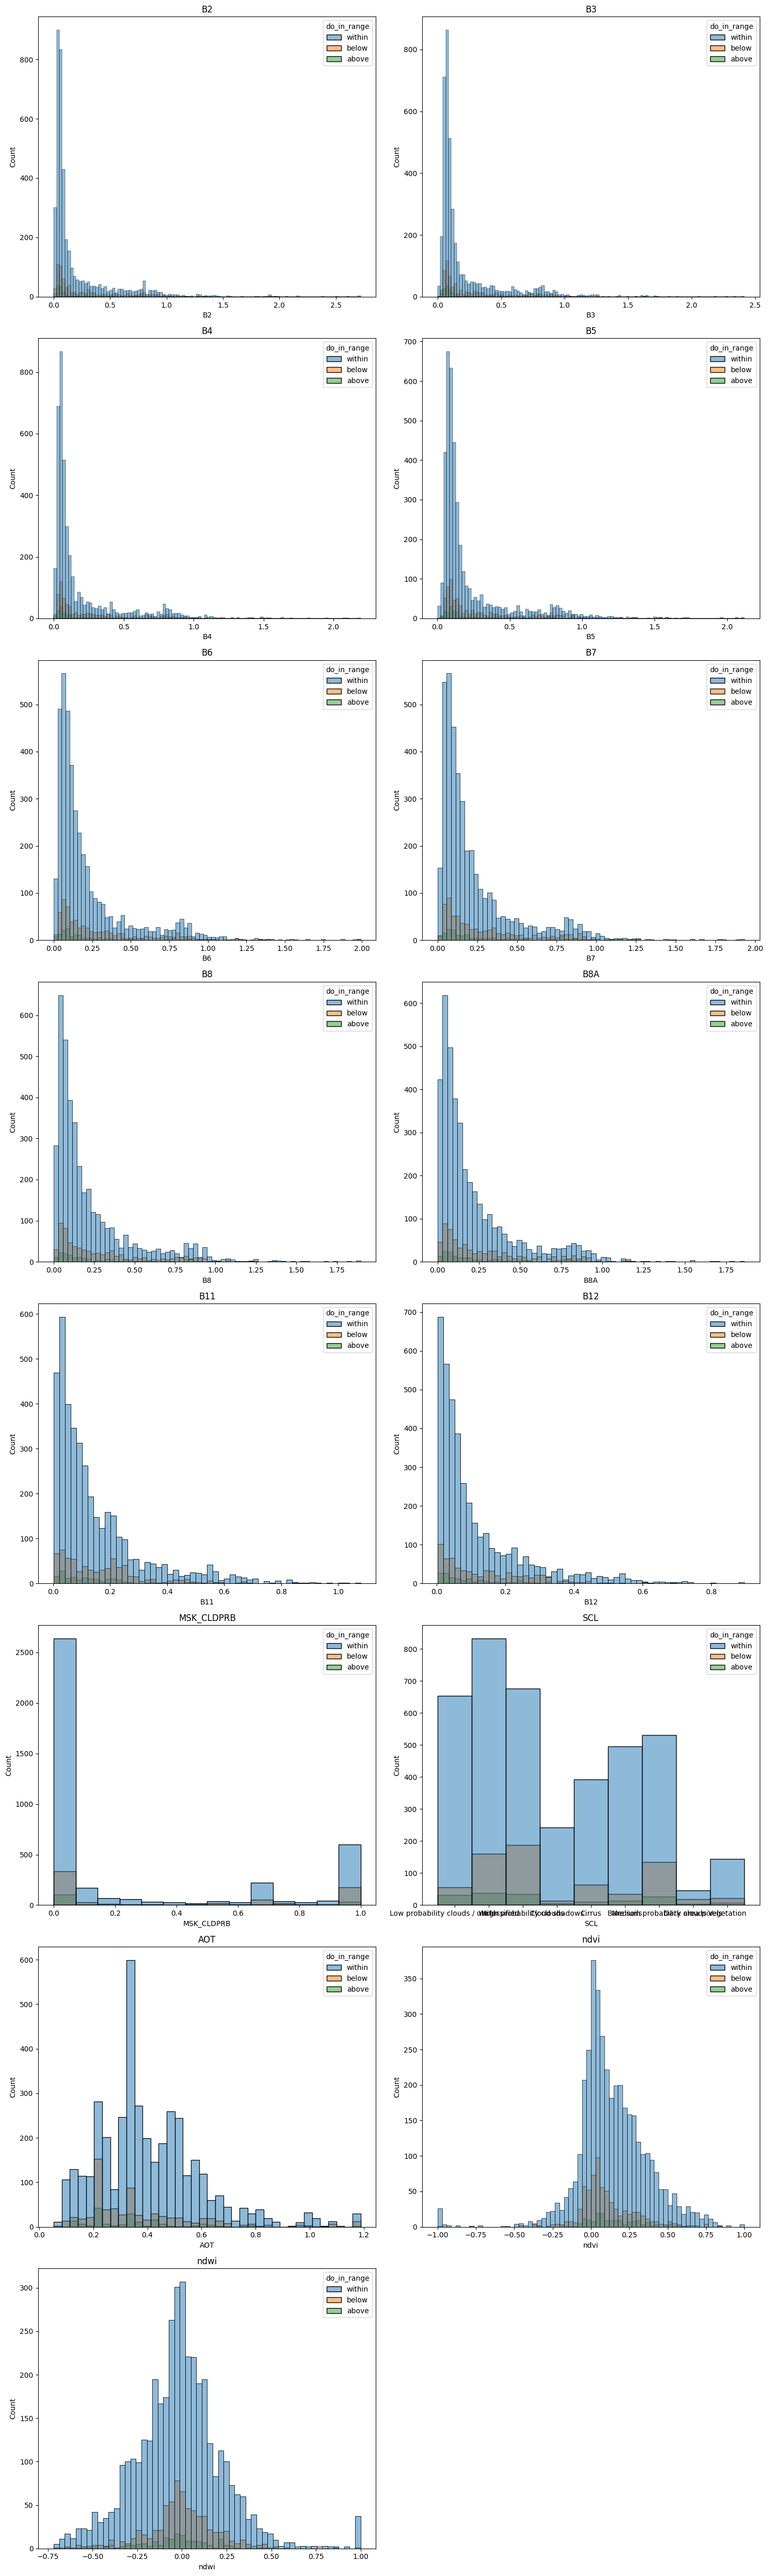

In [35]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_feature_distributions(data, features, hue_var=None, col_var=None, figsize=(12,8)):
    """
    Create histograms for multiple features with optional hue and column grouping.
    
    Args:
        data (pd.DataFrame): Input dataframe containing features
        features (list): List of feature names to plot
        hue_var (str, optional): Column name to use for color grouping
        col_var (str, optional): Column name to use for subplot columns
        figsize (tuple): Base figure size that will be scaled based on features
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    # Calculate grid dimensions
    n_features = len(features)
    n_cols = len(data[col_var].unique()) if col_var else 1
    n_rows = int(np.ceil(n_features / 1))  # 1 feature per row
    
    # Scale figure size based on number of features and columns
    fig_width = figsize[0] * n_cols
    fig_height = figsize[1] * (n_rows/3)
    
    # Create figure and grid
    fig = plt.figure(figsize=(fig_width, fig_height))
    plot_data = data[data[hue_var].astype(bool)]

    # Create subplot for each feature
    for idx, feature in enumerate(features):
        if col_var:
            # Get global min/max for this feature across all col_var values
            feature_min = plot_data[feature].min()
            feature_max = plot_data[feature].max()
            
            # Create a subplot for each unique value in col_var
            for col_idx, col_val in enumerate(sorted(plot_data[col_var].unique())):
                ax = plt.subplot(n_rows, n_cols, idx*n_cols + col_idx + 1)
                
                # Filter data for current col_val
                subset = plot_data[plot_data[col_var] == col_val]
                
                # Create histogram
                sns.histplot(data=subset, x=feature, hue=hue_var, 
                           multiple="layer", alpha=0.5, ax=ax)
                
                # Set title and labels
                ax.set_title(f'{feature} - {col_var}: {col_val}')
                
                # Set consistent x-axis limits for this feature
                ax.set_xlim(feature_min, feature_max)
                
                # Share x-axis limits across rows
                if col_idx > 0:
                    ax.set_ylabel('')
                    
        else:
            # Create subplot in 2x2 grid
            n_subplot_cols = 2
            n_subplot_rows = int(np.ceil(n_features / n_subplot_cols))
            ax = plt.subplot(n_subplot_rows, n_subplot_cols, idx + 1)
            sns.histplot(data=plot_data, x=feature, hue=hue_var,
                        multiple="layer", alpha=0.5, ax=ax)
            ax.set_title(feature)
    
    # Adjust layout
    plt.tight_layout()
    return fig

# Example usage:
features_to_plot = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'MSK_CLDPRB', 'SCL', 'AOT', 'ndvi', 'ndwi']
plot_feature_distributions(predict_df, 
                         features=features_to_plot,
                         hue_var='do_in_range',
                         figsize=(15, 10))
plt.show()

- The two AOT spikes are bizarre. You should investigate those.
- MSKCLDPROB tells similar story to before.

### Check scenes with water classification

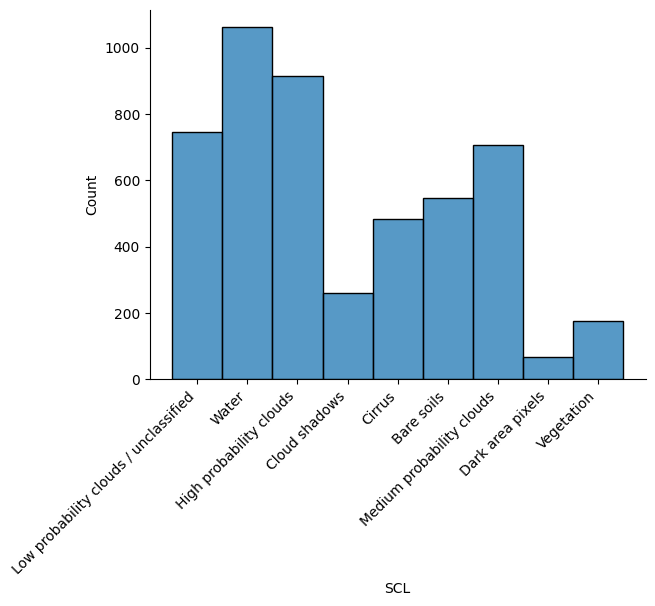

In [24]:
# Create histogram
ax = sns.histplot(predict_df, x='SCL')
plt.xticks(rotation=45, ha='right')
ax.spines[['top', 'right']].set_visible(False)

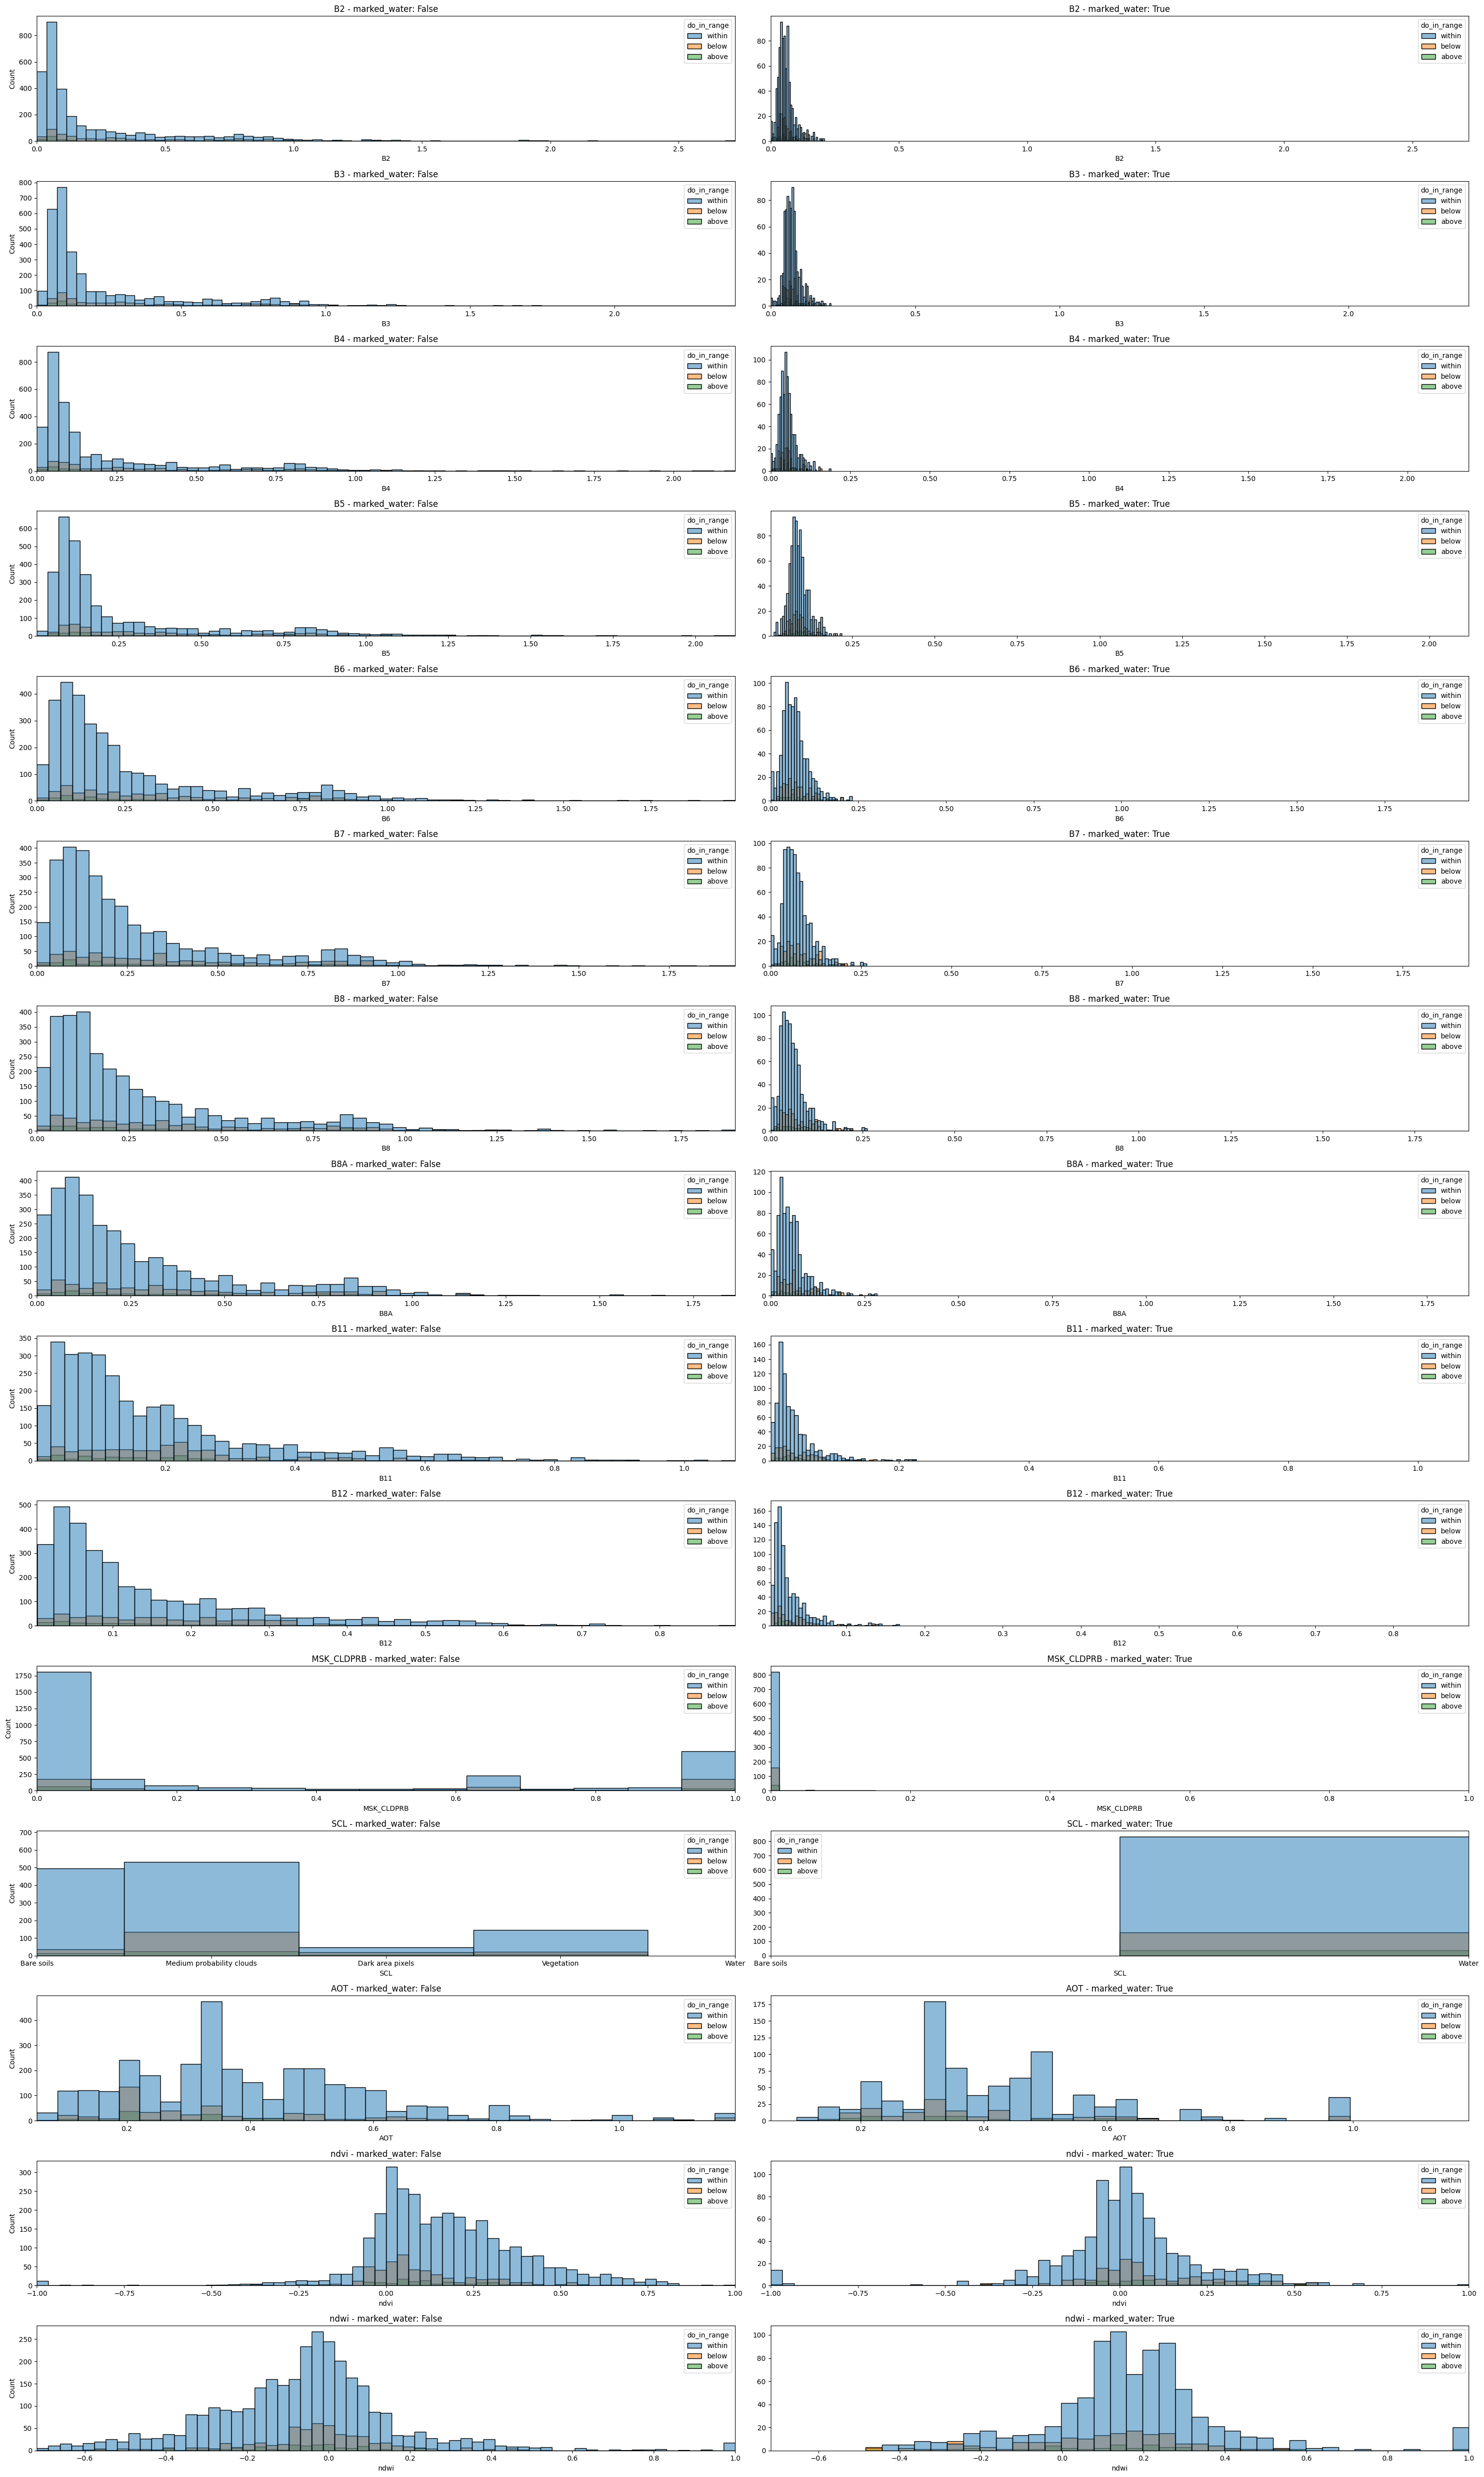

In [39]:
# Example with column grouping
predict_df['marked_water'] = predict_df['SCL'] == 'Water'
plot_feature_distributions(predict_df,
                         	 features=features_to_plot,
                           hue_var='do_in_range',
                           col_var='marked_water',
                           figsize=(15, 10))
plt.show()


C:\Users\squaade\AppData\Local\Temp\ipykernel_57168\3848382940.py:56: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(feature_min, feature_max)
C:\Users\squaade\AppData\Local\Temp\ipykernel_57168\3848382940.py:56: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(feature_min, feature_max)


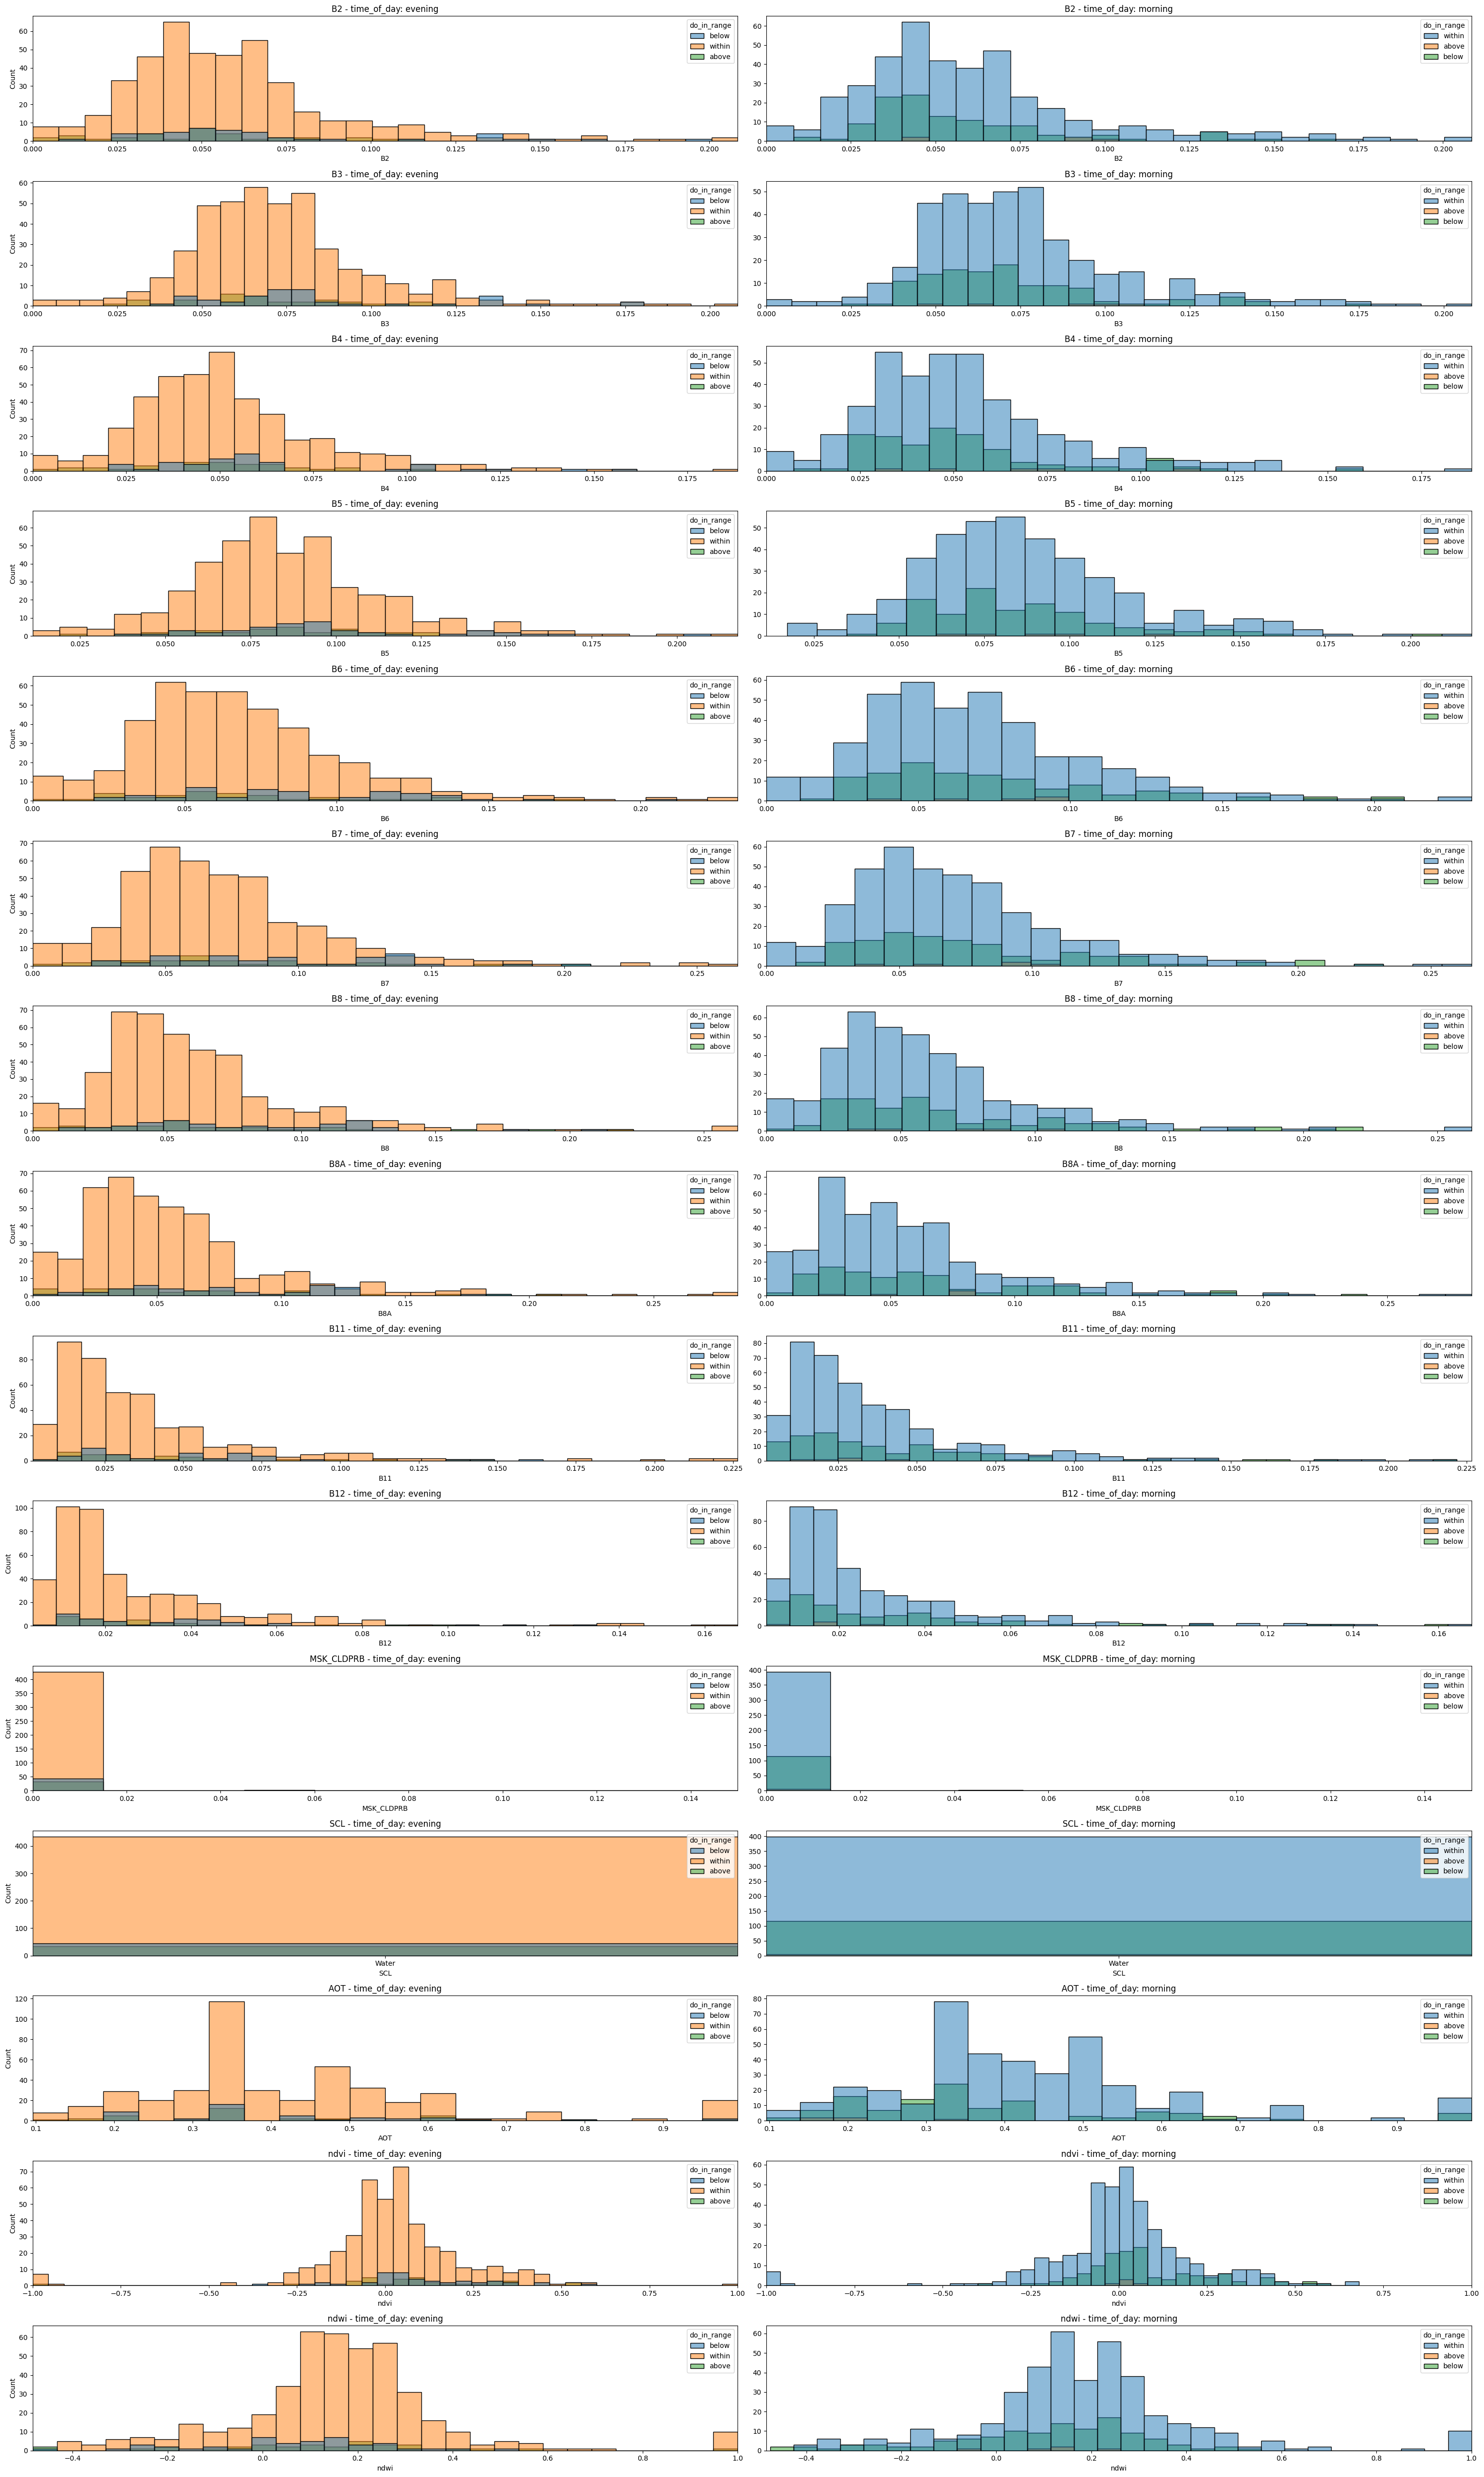

In [85]:
water_df = predict_df[predict_df['SCL'] == 'Water']
plot_feature_distributions(water_df,
                         	 features=features_to_plot,
                           hue_var='do_in_range',
                           col_var='time_of_day',
                           figsize=(15, 10))
plt.show()


- Some of these variables looks like they could be useful. Maybe AOT, maybe b7

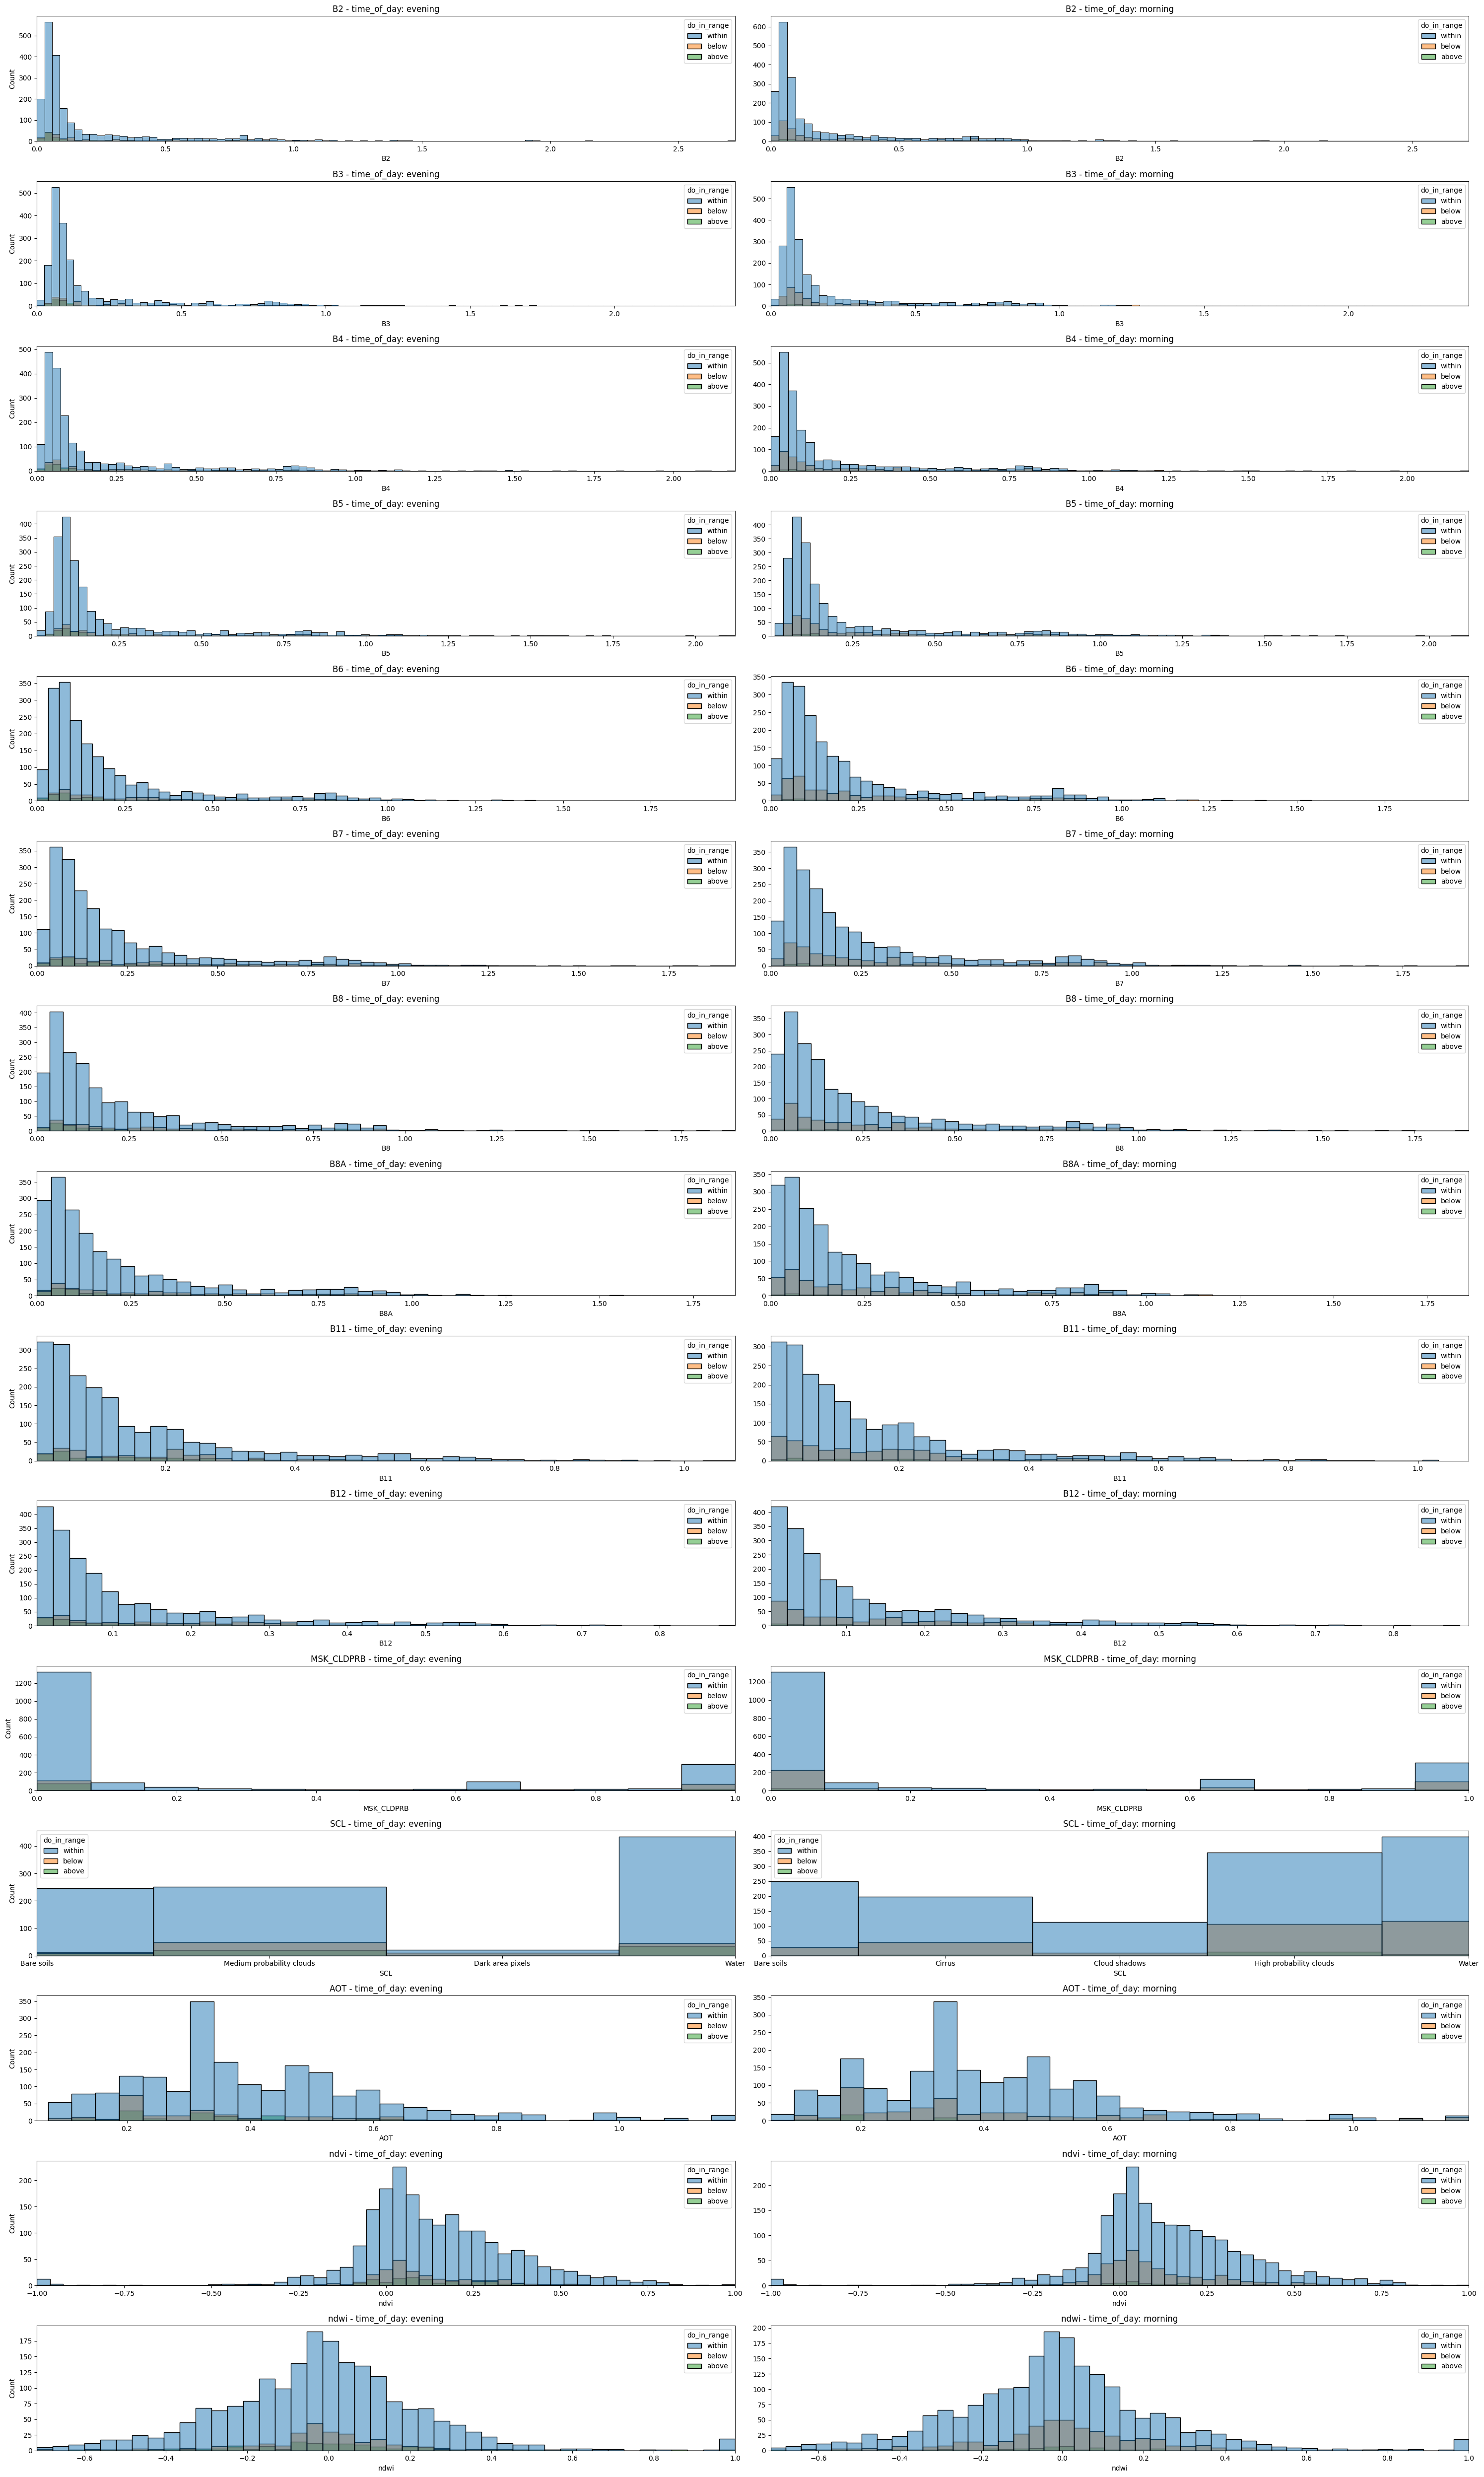

In [42]:
plot_feature_distributions(predict_df,
                         	 features=features_to_plot,
                           hue_var='do_in_range',
                           col_var='time_of_day',
                           figsize=(15, 10))
plt.show()


### Look into the AOT thing

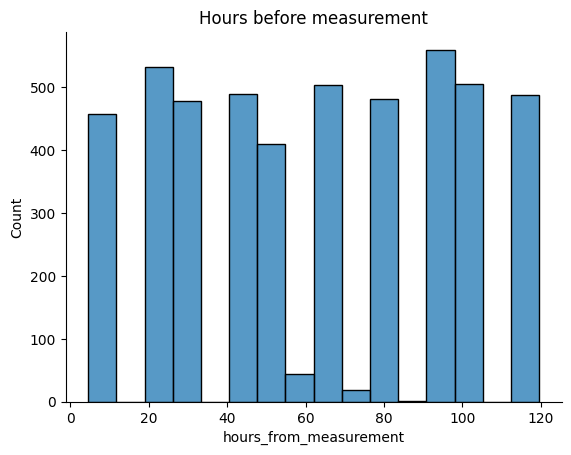

In [56]:
ax = sns.histplot(predict_df, x='hours_from_measurement')
ax.set_title('Hours before measurement')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [67]:
predict_df['sentinel_time'] = predict_df.apply(lambda x: x['sample_dt'] - pd.Timedelta(hours=x['hours_from_measurement']), axis=1)
predict_df['sentinel_days_before'] = predict_df['hours_from_measurement'] // 24
predict_df['sentinel_hour'] = predict_df['sentinel_time'].dt.hour
predict_df['sentinel_tod'] = predict_df['sentinel_hour'] < 12

In [69]:
predict_df['sentinel_hour'].value_counts() # All of the Sentinel-2 images taken at the same time. That's great.

sentinel_hour
10    4969
Name: count, dtype: int64

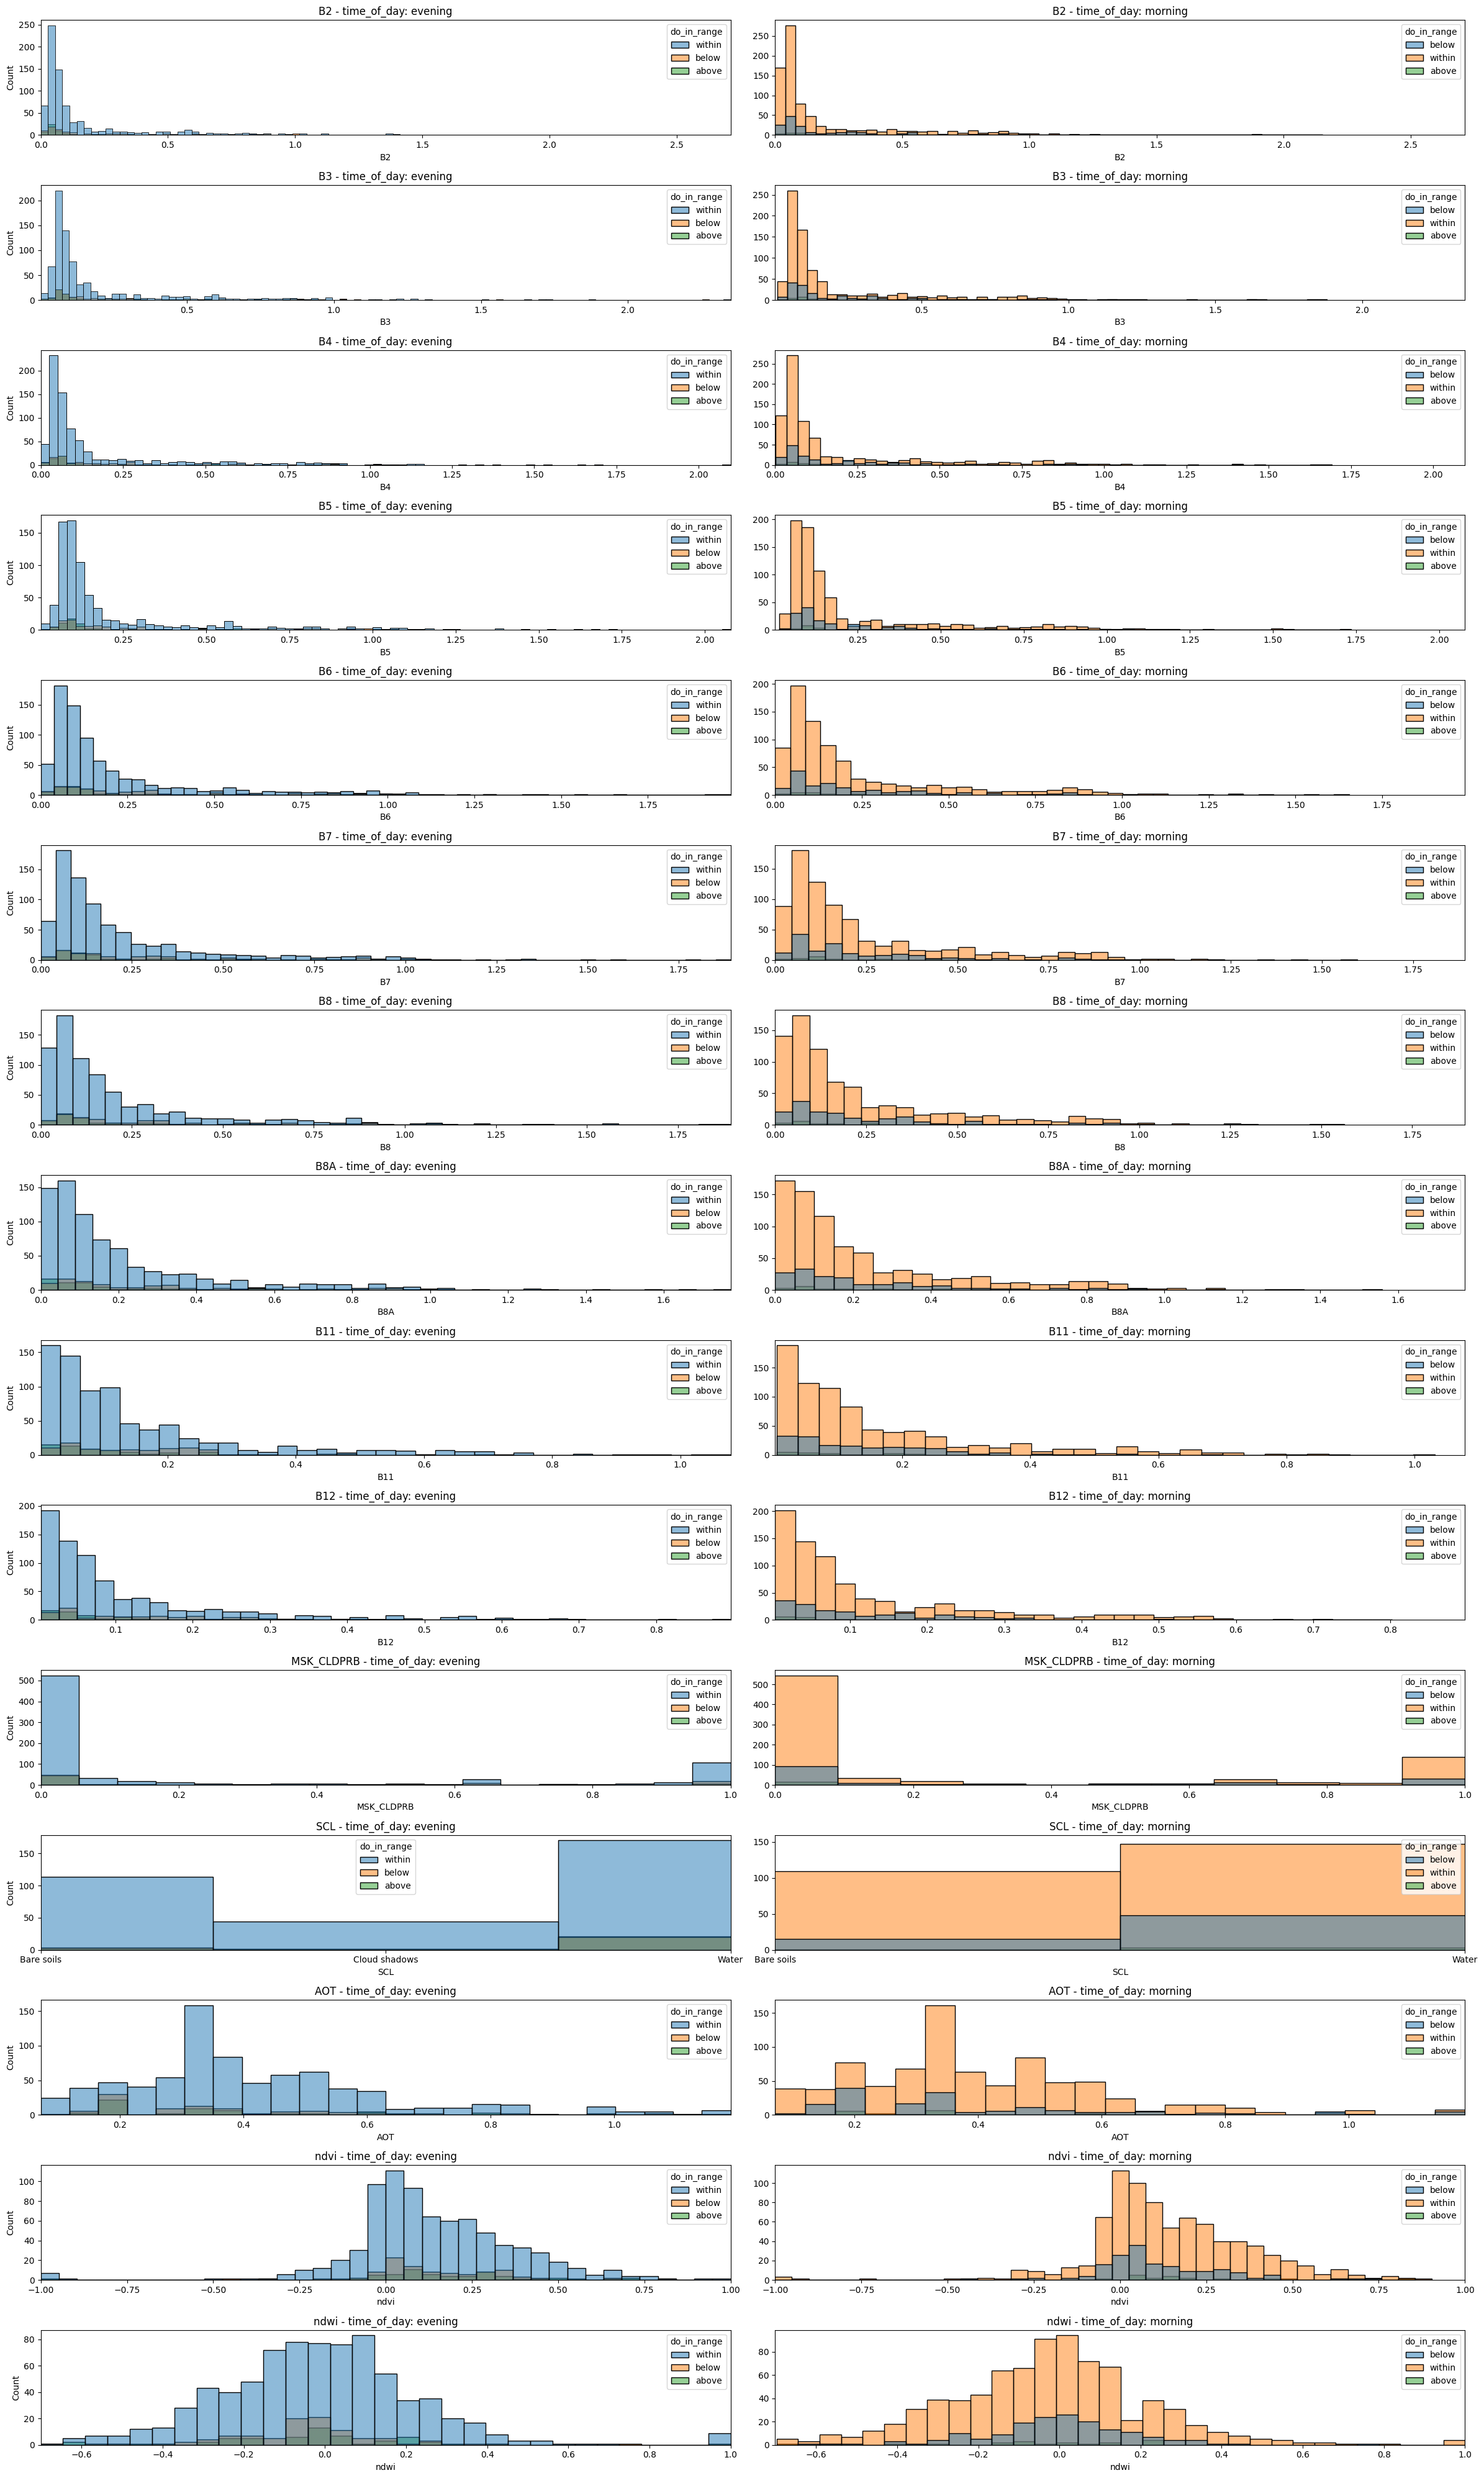

In [71]:
recent_df = predict_df[predict_df['sentinel_days_before'] <= 1]
plot_feature_distributions(recent_df,
                           features_to_plot,
                           hue_var='do_in_range',
                           col_var='time_of_day')
plt.show()

Not clear to me that we're getting better signal by looking at more recent data

In [75]:
predict_df['dodgy_aot'] = predict_df['AOT'].between(0.15, 0.25)

In [76]:
predict_df.columns

Index(['pond_id', 'region', 'farm_id', 'sample_dt', 'do_mg_per_L', 'ph',
       'turbidity_cm', 'ammonia_mg_per_L', 'time_of_day',
       'property_area_acres', 'pond_area_acres', 'pond_depth_meters',
       'sample_idx', 'geometry', 'AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4',
       'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'MSK_CLDPRB', 'SCL',
       'hours_from_measurement', 'ndvi', 'ndwi', 'do_in_range', 'ph_in_range',
       'ammonia_in_range', 'turbidity_in_range', 'marked_water', 'image_time',
       'sentinel_time', 'sentinel_hour', 'sentinel_tod',
       'sentinel_days_before', 'dodgy_aot'],
      dtype='object')

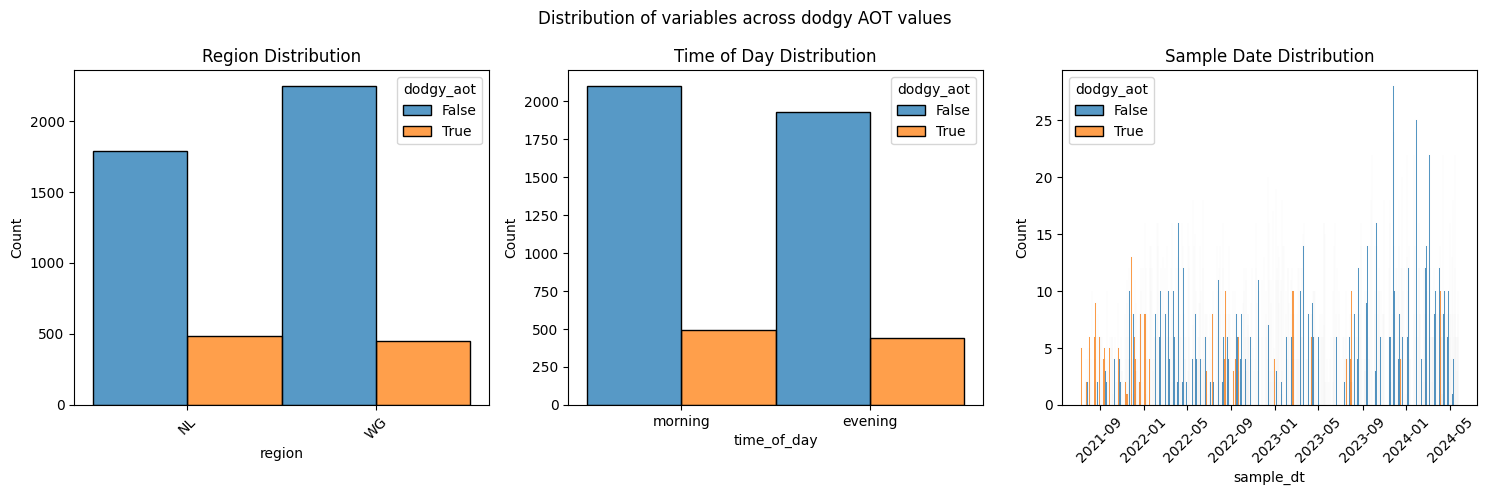

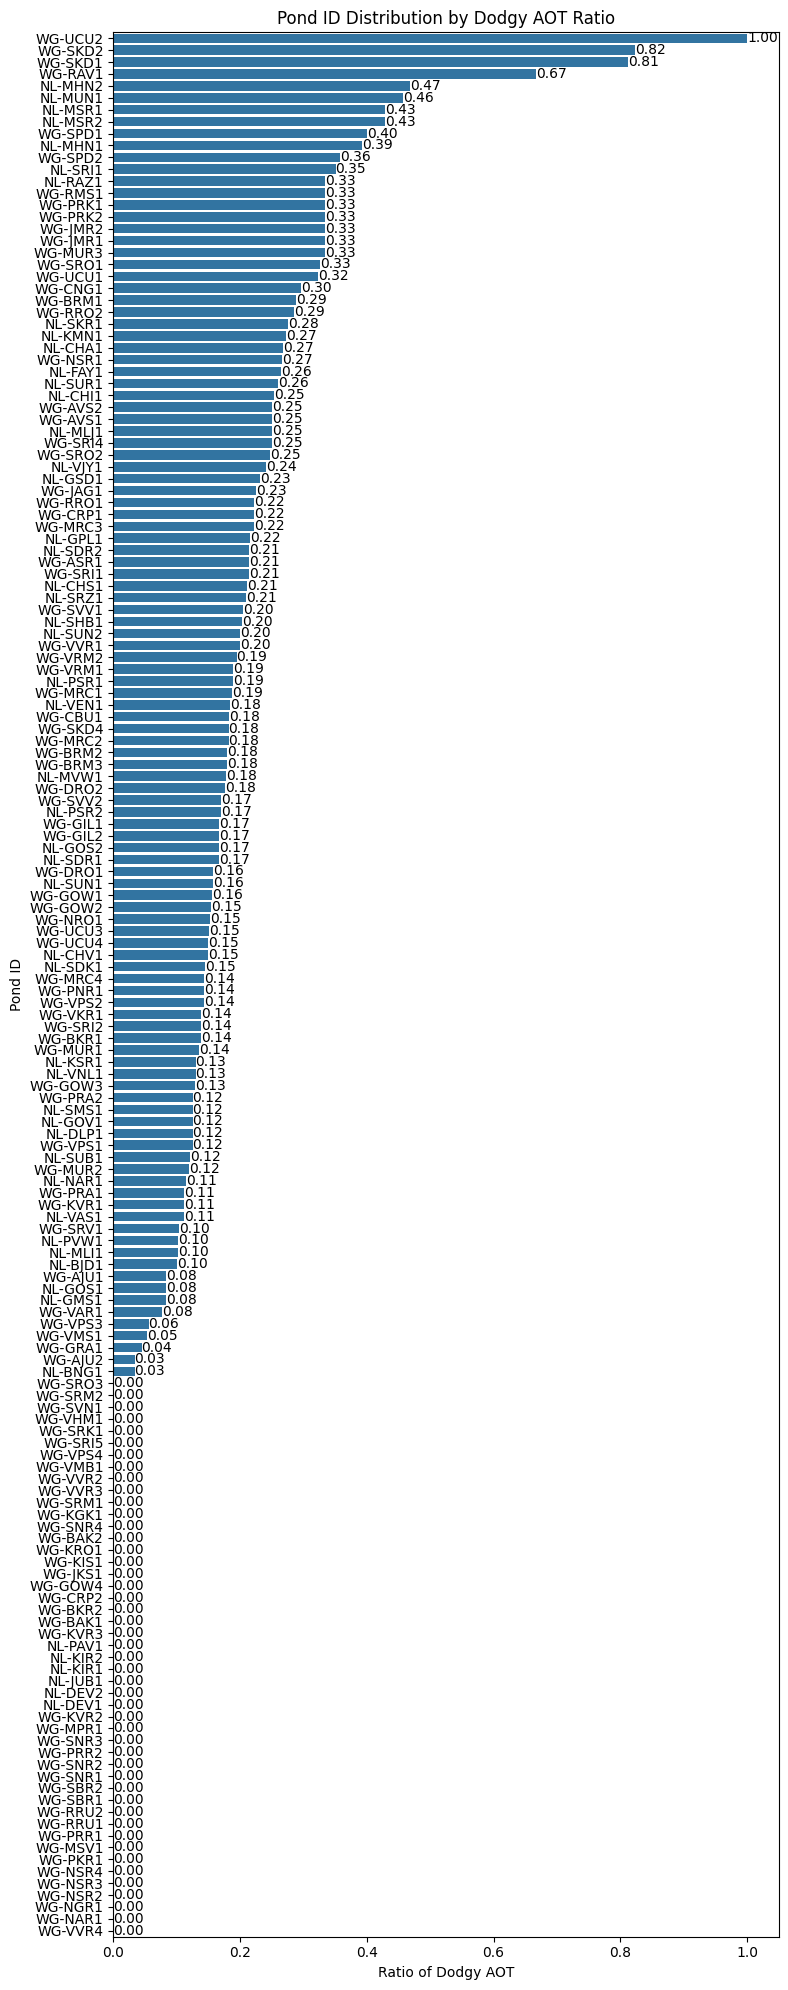

In [83]:
# Plot distribution of categorical variables across dodgy_aot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distribution of variables across dodgy AOT values')

# Region distribution  
sns.histplot(data=predict_df, x='region', hue='dodgy_aot', multiple="dodge", ax=axes[0])
axes[0].set_title('Region Distribution')
axes[0].tick_params(axis='x', rotation=45)

# Time of day distribution
sns.histplot(data=predict_df, x='time_of_day', hue='dodgy_aot', multiple="dodge", ax=axes[1])
axes[1].set_title('Time of Day Distribution')

# Sample date distribution
sns.histplot(data=predict_df, x=predict_df['sample_dt'].dt.date, hue='dodgy_aot', multiple="dodge", ax=axes[2])
axes[2].set_title('Sample Date Distribution')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate dodgy AOT ratio per pond
pond_ratios = predict_df.groupby('pond_id')['dodgy_aot'].mean().sort_values(ascending=False)

# Create separate figure for pond distribution
plt.figure(figsize=(8, 20))
ax = sns.barplot(y=pond_ratios.index, x=pond_ratios.values)
ax.set_title('Pond ID Distribution by Dodgy AOT Ratio')
ax.set_xlabel('Ratio of Dodgy AOT')
ax.set_ylabel('Pond ID')

# Add value labels
for i, v in enumerate(pond_ratios.values):
    ax.text(v, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()

In [90]:
pond_ratios

do_in_range,,above,below,within
pond_id,,,,
NL-BJD1,NaN,NaN,0.000000,0.111111
NL-BNG1,NaN,NaN,0.000000,0.035714
NL-CHA1,NaN,0.75,0.384615,0.203704
NL-CHI1,NaN,0.50,0.470588,0.166667
NL-CHS1,NaN,1.00,NaN,0.196429
...,...,...,...,...
WG-VRM2,NaN,0.00,0.428571,0.180328
WG-VVR1,NaN,NaN,0.500000,0.125000
WG-VVR2,NaN,NaN,NaN,0.000000


I'm going to guess that the AOT thing is an artifact. 